# Read and visualize spatial data from a database (MariaDB)

## Install requirements


#### Create and activate conda environment.
```bash
conda create -n geoviz python==3.12
conda activate geoviz
```

#### Install and start mariadb.

```bash
brew install mariadb
brew services start mariadb
```

#### Install pip dependencies.

```bash
pip install mariadb numpy pandas geopandas shapely matplotlib folium mapclassify contextily
```

#### Set up mariadb access rights (optional).

```bash
sudo mysql_secure_installation
```

#### Create user and database.

First connect to the database from command line.

```bash
mysql -u root -p
```

Then execute this SQL (copy and paste) to create a user called `geoviz` with password `geoviz`.

```sql
CREATE DATABASE geoviz;
CREATE USER 'geoviz'@'localhost' IDENTIFIED BY 'geoviz';
GRANT ALL PRIVILEGES ON geoviz.* TO 'geoviz'@'localhost';
FLUSH PRIVILEGES;
EXIT;
```



## Start coding

Create connect and disconnect function to make the coding easier later on.

In [65]:
import mariadb
import sys

def connect():
    # Connect to MariaDB Platform
    try:
        conn = mariadb.connect(
            user="geoviz",
            password="geoviz",
            host="localhost",
            port=3306,
            database="geoviz"

        )
    except mariadb.Error as e:
        print(f"Error connecting to MariaDB Platform: {e}")
        sys.exit(1)

    # Get Cursor
    cur = conn.cursor()
    return cur, conn

def disconnect(cur, conn):
    # Close connection
    cur.close()
    conn.close()
    

Define functions for creating the database and table.

Also, define utility functions for querying the db.

In [113]:
def create_db():
  cur, conn = connect()
  cur.execute("CREATE DATABASE IF NOT EXISTS geoviz")
  disconnect(cur, conn)

def create_table():
  cur, conn = connect()
  # Create table with spatial column
  cur.execute("""
    CREATE TABLE IF NOT EXISTS geoviz (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        geom GEOMETRY NOT NULL,
        SPATIAL INDEX(geom)
    )
    """)
  disconnect(cur, conn)

def clear_table():
  cur, conn = connect()
  # Create table with spatial column
  cur.execute("TRUNCATE TABLE geoviz;")
  disconnect(cur, conn)

def get_all_rows():
  cur, conn = connect()
  cur.execute("SELECT id, name, ST_AsText(geom) AS geom FROM geoviz")
  rows = cur.fetchall()
  columns = [desc[0] for desc in cur.description]
  disconnect(cur, conn)
  return rows, columns

### Insert data into database

In [117]:
from shapely.geometry import Point


def insert_data():
  cur, conn = connect()
  coords = [
    (13.186, 55.707), # Lund, Sweden
  ]
  for pair in coords:
    point = Point(pair)
    wkt = point.wkt

    # Insert point into the table
    insert_query = "INSERT INTO geoviz (name, geom) VALUES (%s, ST_GeomFromText(%s))"
    cur.execute(insert_query, ("Example Point", wkt))
    conn.commit()
  disconnect(cur, conn)

clear_table()
insert_data()

# Verify insertion
rows, cols = get_all_rows()
print('Columns:', cols)
print('Rows:', [row for row in rows])


Columns: ['id', 'name', 'geom']
Rows: [(1, 'Example Point', 'POINT(13.186 55.707)')]


### Read points and plot a map

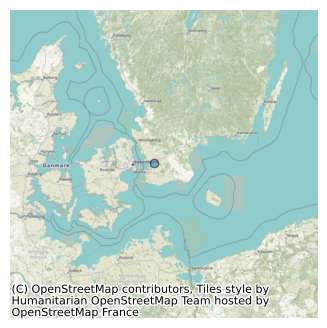

In [194]:
import geopandas as gpd
import pandas as pd
import contextily as cx
from shapely import wkt
import matplotlib.pyplot as plt

def get_df():
  # Fetch data and convert to GeoDataFrame
  rows, cols = get_all_rows()
  df = pd.DataFrame(rows, columns=cols)
  df['geom'] = df['geom'].apply(wkt.loads)
  gdf = gpd.GeoDataFrame(df, geometry='geom')
  gdf = gdf.set_crs(epsg=4326)
  return gdf

gdf = get_df()
# gdf.explore(color='red', figsize=(10, 10), cmap="Set1", style_kwds=dict(color="yellow", weight=4, radius=12))
gdf_3857 = gdf.to_crs(epsg=3857)
ax = gdf_3857.plot(figsize=(12, 4), alpha=0.5, edgecolor="k", legend=True)
ax.set_aspect('equal')
ax.set_axis_off()
plt.xlim(1000000, 2000000)
plt.ylim(7000000, 8000000)
cx.add_basemap(ax, crs=gdf_3857.crs) # source=cx.providers.CartoDB.Positron)


## That's it!

### Concluding thoughts

- It is not so hard to do spatial work with Python
- It gives more flexibility compared to using products like ArcGIS och QGIS
- Python can also be combined with mentioned software for creating customised solutions (TODO :))